In [1]:
import scanpy as sc
import pandas as pd
import sys

In [2]:
import echidna as ec
import matplotlib.pyplot as plt
import torch
from scipy.stats import linregress
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list, fcluster
from matplotlib.colors import ListedColormap
ec.pl.activate_plot_settings()

In [3]:
def get_binned_DNA_orig(adata, DNA, map, eta):
  barcodes = list(adata.obs_names)
  for i in range(len(barcodes)):
    barcodes[i] = barcodes[i].split("_")[0]
  barcodes_overlap = set(barcodes).intersection(set(DNA.columns))

  DNA = DNA[barcodes]
  DNA = DNA / np.array(DNA).mean(axis=0) * 2 # THIS STEP IS DESCRIBED IN THE PUBLISHED PAPER THIS DATA CAME FROM


  eta_df = pd.DataFrame(eta.cpu().detach().numpy())
  eta_df.columns = adata.var_names

  DNA_clus = pd.DataFrame()
  for cluster in eta_df.index:
    DNA_cluster = []
    obs = adata.obs
    for i in range(len(obs['leiden'].unique())):
        #inds = obs[obs["leiden"]==str(i)].index
        inds = obs[obs["leiden"]==i].index
        inds = [i.split("_")[0] for i in inds]
        DNA_cluster.append(list(DNA[inds].mean(axis=1)))

    DNA_cluster = pd.DataFrame(DNA_cluster)

    gene_names = []
    W1 = []
    for i in range(DNA_cluster.shape[1]):
        genes = str.split(map.iloc[i]["genes"],",")
        gene_names+=genes
        W1+=[DNA_cluster.loc[cluster][i] for j in range(len(genes))]

    DNA_clus[cluster] =  W1
  DNA_clus.index = gene_names
  return DNA_clus, DNA_cluster

In [4]:
# helper function for binning
def binning_eta(df):
    binned = []
    discard_bins = []
    for id, row in map.iterrows():
        genes = str.split(row['genes'],",")
        overlap = list(set(df.columns).intersection(set(genes)))
        in_bin = df[overlap]
        if np.array(in_bin).shape[1] == 0:
            discard_bins.append(id)
            continue
        bin_col = np.array(in_bin).mean(axis=1)
        binned.append(bin_col.reshape(-1, 1))
    binned = np.concatenate(binned, axis=1)
    return binned, discard_bins

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, adjusted_mutual_info_score
from scipy.stats import entropy, ttest_ind
from collections import Counter

def compute_purity(ground_truth, predicted):
    """Compute Purity Score"""
    contingency_matrix = pd.crosstab(ground_truth, predicted)
    return np.sum(np.amax(contingency_matrix.values, axis=0)) / np.sum(contingency_matrix.values)

def bootstrap_metric(ground_truth, predicted, metric_func, n_bootstrap=100):
    """Compute bootstrapped mean and standard deviation for a given metric."""
    bootstrap_scores = []
    n = len(ground_truth)
    for _ in range(n_bootstrap):
        indices = np.random.choice(n, n, replace=True)
        score = metric_func(ground_truth[indices], predicted[indices])
        bootstrap_scores.append(score)
    return np.mean(bootstrap_scores), np.std(bootstrap_scores)

def evaluate_clustering_metrics(adata, ground_truth_label, labels):
    """Compute clustering metrics for labels in an AnnData object."""
    metrics = {}
    for label in labels:
        ground_truth = adata.obs[ground_truth_label].values
        predicted = adata.obs[label].values

        purity_mean, purity_std = bootstrap_metric(ground_truth, predicted, compute_purity)
        nmi_mean, nmi_std = bootstrap_metric(ground_truth, predicted, normalized_mutual_info_score)
        ami_mean, ami_std = bootstrap_metric(ground_truth, predicted, adjusted_mutual_info_score)
        ari_mean, ari_std = bootstrap_metric(ground_truth, predicted, adjusted_rand_score)

        metrics[label] = {
            'Purity': (purity_mean, purity_std),
            'NMI': (nmi_mean, nmi_std),
            'AMI': (ami_mean, ami_std),
            'ARI': (ari_mean, ari_std)
        }
    return pd.DataFrame(metrics).T

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Tab10: blue, orange, green, red, purple …
_COLOR_MAP = {
    "echidna":   plt.cm.tab10.colors[0],   # blue
    "inferCNV":  plt.cm.tab10.colors[1],   # orange
    "numbat":    plt.cm.tab10.colors[2],   # green
    "CopyKAT":   plt.cm.tab10.colors[3],   # red
    "XClone":    plt.cm.tab10.colors[4],   # purple
}

def _star(p):
    if p < 1e-10:
        return '***'
    if p < 1e-5:
        return '**'
    if p < 0.05:
        return '*'
    return ''

def plot_metric_bar_clone_call(ax, metric, data, dataset_name, orientation="vertical"):
    """
    Plot a metric for echidna / inferCNV / numbat / CopyKAT / XClone.

    data rows must be '<tool>_clones' each with (mean, err).  Bars are sorted
    high→low but coloured fixed via _COLOR_MAP.  Stars show significance vs.
    the top bar (Echidna etc.).
    """
    tools   = ["echidna", "inferCNV", "numbat", "CopyKAT", "XClone"]
    rows    = [f"{t}_clones" for t in tools]

    # ------------------------------------------------------------------ #
    # 1) pull values
    # ------------------------------------------------------------------ #
    means, errs = [], []
    for r in rows:
        m, e = data.loc[r, metric] if r in data.index else (0.0, 0.0)
        means.append(m); errs.append(e)

    # sort by mean descending
    order  = np.argsort(means)[::-1]
    means  = [means[i]  for i in order]
    errs   = [errs[i]   for i in order]
    labels = [tools[i]  for i in order]

    # geometry
    n_bars  = len(labels)        # now 5
    width   = 0.14               # a bit narrower to fit five bars
    offsets = (np.arange(n_bars) - (n_bars-1)/2) * width
    x       = np.arange(len(dataset_name))

    if orientation == "horizontal":
            for j, off in enumerate(offsets):
                ax.barh(x + off, means[j], height=width,
                        xerr=errs[j], alpha=0.7,
                        label=labels[j],
                        color=_COLOR_MAP[labels[j]])

            ax.set_yticks(x)
            ax.set_yticklabels(dataset_name, fontsize=14)
            ax.set_xlabel(metric, fontsize=16)
            ax.grid(True, axis="x", linestyle="--", alpha=0.6)
            ax.legend(fontsize=10, ncol=1)
            max_x = max(m + e for m, e in zip(means, errs))
            ax.set_xlim(0, max_x + 0.3)

            # significance stars (vs. best bar) – *no connecting lines*
            for i in range(len(dataset_name)):
                np.random.seed(42)
                ref = np.random.normal(means[0], errs[0], 100)
                for j in range(1, n_bars):
                    comp = np.random.normal(means[j], errs[j], 100)
                    star = _star(ttest_ind(ref, comp).pvalue)
                    if star:
                        y_pos = x[i] + offsets[j]               # bar’s vertical centre
                        x_pos = means[j] + errs[j] + 0.02*max_x # just beyond bar end
                        ax.text(x_pos, y_pos, star, va='center',
                                ha='left', fontsize=11)

    # ------------------------------------------------------------------ #
    # vertical
    # ------------------------------------------------------------------ #
    else:
        for j, off in enumerate(offsets):
            ax.bar(x + off, np.abs(means[j]), width,
                yerr=np.abs(errs[j]), alpha=0.7,
                label=labels[j],
                color=_COLOR_MAP[labels[j]])

        ax.set_xticks(x)
        ax.set_xticklabels(dataset_name, fontsize=14, rotation=15)
        ax.set_ylabel(metric, fontsize=16)
        ax.grid(True, axis="y", linestyle="--", alpha=0.6)
        ax.legend(fontsize=10, ncol=1)
        max_y = max(m + e for m, e in zip(means, errs))
        ax.set_ylim(0, max_y + 0.3)

        # significance stars (vs. best bar) – *no connecting lines*
        for i in range(len(dataset_name)):
            np.random.seed(42)
            ref = np.random.normal(means[0], errs[0], 100)
            for j in range(1, n_bars):
                comp = np.random.normal(means[j], errs[j], 100)
                star = _star(ttest_ind(ref, comp).pvalue)
                if star:
                    x_pos = x[i] + offsets[j]               # bar centre
                    y_pos = means[j] + errs[j] + 0.02*max_y # just above bar top
                    ax.text(x_pos, y_pos, star, ha='center',
                            va='bottom', fontsize=11)

In [7]:
import numpy as np
import pandas as pd
from typing import Sequence, List, Dict, Any
from scipy.stats import pearsonr, spearmanr
from numpy.linalg import norm

def evaluate_regression_metrics(
    Xs: Sequence[np.ndarray],
    Ys: Sequence[np.ndarray],
    models: List[str],
    *,
    n_boot: int = 1_000,
    ci: float = 95,
    random_state: int = 0,
) -> pd.DataFrame:
    """
    For each (x, y) pair compute Pearson-r, Spearman-ρ, and cosine similarity
    with bootstrap CIs.  Returns DataFrame whose cells are
        (point_estimate, (ci_low, ci_high))
    """
    rng   = np.random.default_rng(random_state)
    alpha = (100 - ci) / 2           # 95 % ⇒ 2.5 / 97.5 percentiles
    rows: Dict[str, Dict[str, Any]] = {}

    for name, x, y in zip(models, Xs, Ys):
        x, y = x.ravel(), y.ravel()
        n    = x.size

        # ---------- point estimates ----------
        pearson_val  = pearsonr(x, y).statistic
        spearman_val = spearmanr(x, y).correlation
        cos_val      = float(np.dot(x, y) / (norm(x) * norm(y)))

        # ---------- bootstrap ----------
        p_dist, s_dist, c_dist = [], [], []
        for _ in range(n_boot):
            idx        = rng.choice(n, n, replace=True)
            xb, yb     = x[idx], y[idx]
            p_dist.append(pearsonr(xb, yb).statistic)
            s_dist.append(spearmanr(xb, yb).correlation)
            c_dist.append(float(np.dot(xb, yb) / (norm(xb) * norm(yb))))

        def ci_bounds(dist):
            return np.percentile(dist, [alpha, 100 - alpha])

        pear_lo,  pear_hi  = ci_bounds(p_dist)
        spear_lo, spear_hi = ci_bounds(s_dist)

        # ---------- assemble ----------
        rows[name] = {
            "PearsonR":   (pearson_val,  (pear_lo,  pear_hi)),
            "SpearmanR":  (spearman_val, (spear_lo, spear_hi))
        }

    return pd.DataFrame.from_dict(rows, orient="index")

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# ------------------------------------------------------------------ #
# colour map (extend if you add more tools)
# ------------------------------------------------------------------ #
_COLOR_MAP = {
    "echidna":   plt.cm.tab10.colors[0],
    "inferCNV":  plt.cm.tab10.colors[1],
    "numbat":    plt.cm.tab10.colors[2],
    "CopyKAT":   plt.cm.tab10.colors[3],
    "XClone":    plt.cm.tab10.colors[4],
}

def _star(p):
    if p < 1e-10: return '***'
    if p < 1e-5:  return '**'
    if p < 0.05:  return '*'
    return ''

# ------------------------------------------------------------------ #
# single-metric bar plot
# ------------------------------------------------------------------ #
def plot_metric_ba_reg(
    ax,
    metric: str,
    data,                     # DataFrame from evaluate_regression_metrics
    orientation: str = "vertical",
    capsize: int = 4,
):
    """
    Plot `metric` for every model in `data`.

    Each cell in `data` is (mean, (ci_low, ci_high)).
    Bars are sorted high→low, coloured via _COLOR_MAP,
    and model names appear only in the legend (no tick labels).
    """

    # -------- gather --------------------------------------------------------
    tools      = list(data.index)
    means      = []
    err_low    = []
    err_high   = []

    for t in tools:
        mean, (lo, hi) = data.loc[t, metric]
        means.append(mean)
        err_low.append(mean - lo)
        err_high.append(hi - mean)

    # sort best → worst
    order      = np.argsort(means)[::-1]
    means      = [means[i]      for i in order]
    err_low    = [err_low[i]    for i in order]
    err_high   = [err_high[i]   for i in order]
    labels     = [tools[i]      for i in order]
    colours    = [_COLOR_MAP.get(l, "grey") for l in labels]

    # -------- draw ----------------------------------------------------------
    handles = []
    if orientation == "horizontal":
        y_pos = np.arange(len(labels))
        for j, lab in enumerate(labels):
            h = ax.barh(
                y_pos[j],
                means[j],
                xerr=[[err_low[j]], [err_high[j]]],
                color=colours[j],
                alpha=0.85,
                capsize=capsize,
            )
            handles.append(h[0])

        ax.set_yticks([])                         # <- no tick labels
        ax.set_xlabel(metric, fontsize=20)
        ax.grid(axis="x", linestyle="--", alpha=0.4)

        # significance stars vs. top bar
        ref = np.random.normal(means[0], np.mean([err_low[0], err_high[0]]), 500)
        for j in range(1, len(labels)):
            comp = np.random.normal(
                means[j], np.mean([err_low[j], err_high[j]]), 500
            )
            star = _star(ttest_ind(ref, comp).pvalue)
            if star:
                ax.text(
                    means[j] + err_high[j] + 0.02 * max(means),
                    y_pos[j],
                    star,
                    va="center",
                    fontsize=12,
                )

    else:  # vertical
        x_pos = np.arange(len(labels))
        for j, lab in enumerate(labels):
            h = ax.bar(
                x_pos[j],
                means[j],
                yerr=[[err_low[j]], [err_high[j]]],
                color=colours[j],
                alpha=0.85,
                capsize=capsize,
            )
            handles.append(h[0])

        ax.set_xticks([])                         # <- no tick labels
        ax.set_ylabel(metric, fontsize=20)
        ax.grid(axis="y", linestyle="--", alpha=0.4)

        ref = np.random.normal(means[0], np.mean([err_low[0], err_high[0]]), 500)
        for j in range(1, len(labels)):
            comp = np.random.normal(
                means[j], np.mean([err_low[j], err_high[j]]), 500
            )
            star = _star(ttest_ind(ref, comp).pvalue)
            if star:
                ax.text(
                    x_pos[j],
                    means[j] + err_high[j] + 0.02 * max(means),
                    star,
                    ha="center",
                    fontsize=11,
                )

    # legend instead of ticks
    ax.legend(handles, labels, fontsize=16, frameon=False, loc="upper right")

# Load Echidna

In [9]:
adata = sc.read_h5ad("/home/mingxuanzhang/echidna/data/def_seq_data/DEFND_6k_steps.h5")
adata

AnnData object with n_obs × n_vars = 643 × 18587
    obs: 'cell_type', 'rna_cluster', 'rna_umis', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_original_total_counts', 'leiden', 'timepoint', 'echidna_split', 'rna_cluster_categorical', 'echidna_clones'
    var: 'gend_id', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'echidna_matched_genes', 'echidna_W_1'
    uns: 'cell_type_colors', 'echidna', 'echidna_clones_colors', 'leiden', 'log1p', 'neighbors', 'rank_genes_groups', 'rna_cluster_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [11]:
config = ec.tl.EchidnaConfig(
    timepoint_label = "timepoint", 
    counts_layer = "counts",
    clusters = "rna_cluster", 
    num_cells= adata.shape[0],
    num_genes = adata.shape[1],
    inverse_gamma = True, 
    patience = -1,
    n_steps = 5000,
    val_split = .1,
    learning_rate = .1,
    q_corr_init = 1e-2, 
    q_shape_rate_scaler = 10.0,
    eta_mean_init = 2.0,
    lkj_concentration = 1.0,
)

In [12]:
ech = ec.tl.load_model(adata, model_config=config, save_folder="/home/mingxuanzhang/echidna/model_def")
ech

In [13]:
eta = ech.eta_posterior
eta.shape

torch.Size([4, 18587])

In [14]:
ec.tl.echidna_clones(adata, threshold=0.02, link_method='ward', link_metric='euclidean')

/home/mingxuanzhang/echidna/echidna/tools/eval.py:375: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hier_colors = [color_dict.loc[int(i)][0] for i in adata.obs[cluster_label]]
2025-07-22 03:55:41,189 | INFO : Added `.obs['echidna_clones']`: the learned clones from eta.


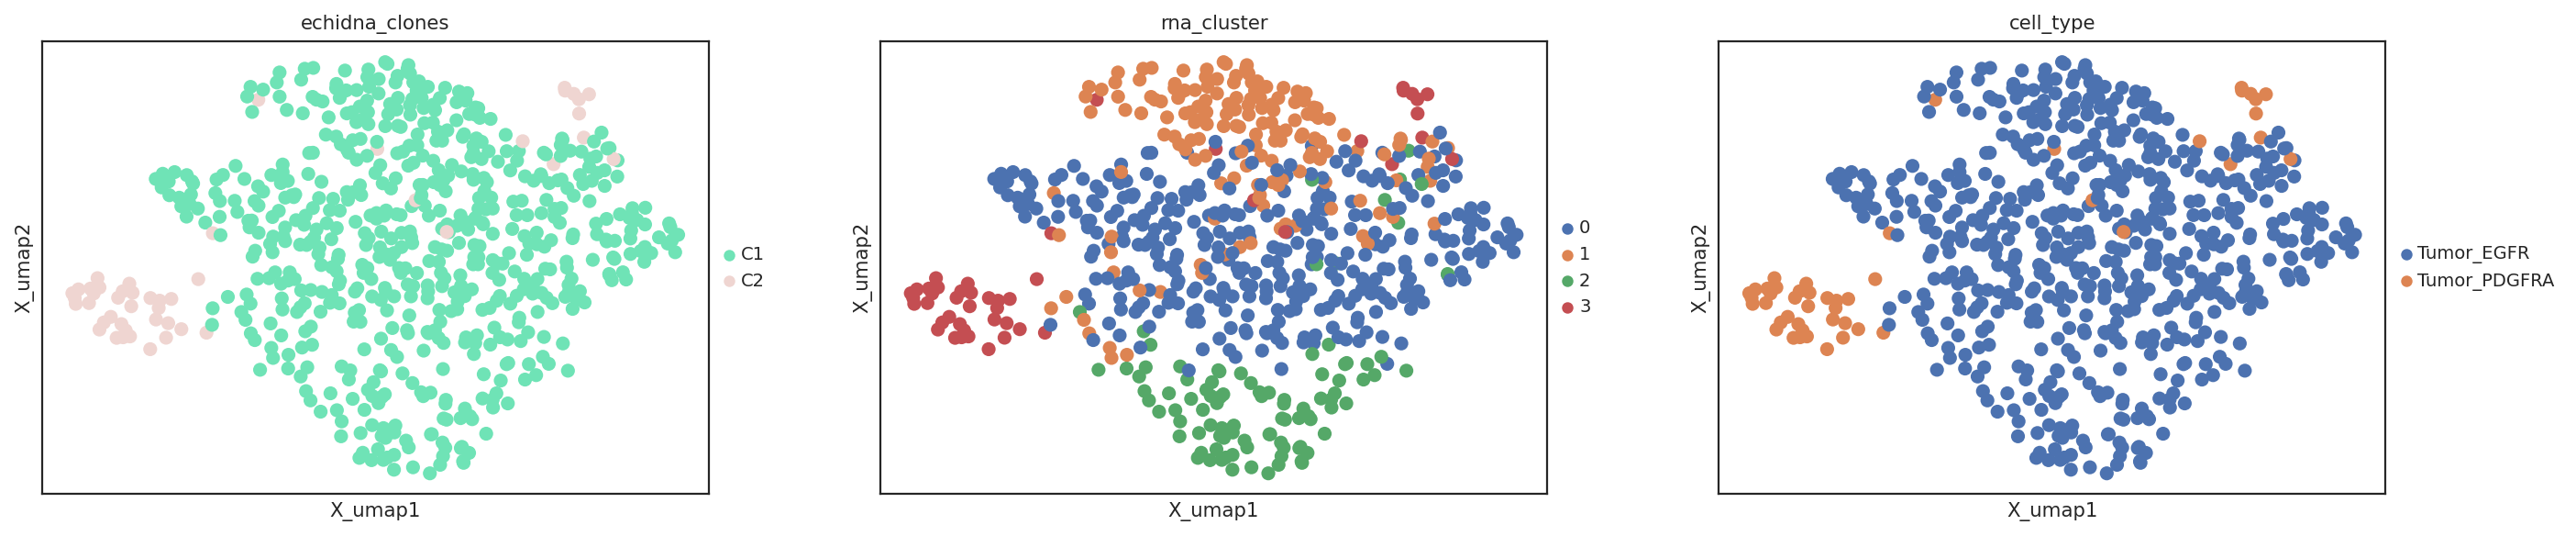

In [15]:
adata.obs["rna_cluster"] = pd.Categorical(adata.obs["rna_cluster"])
ec.pl.echidna(adata, ["echidna_clones", "rna_cluster","cell_type"])

In [16]:
tumor2 = adata.copy()
tumor2.obs['barcode_infercnv'] = [i.split("_")[0] for i in tumor2.obs_names]
tumor2.obs['barcode_numbat'] = [i.split("_")[0] for i in tumor2.obs_names]
tumor2.obs['barcode_orig'] = tumor2.obs_names
tumor2

AnnData object with n_obs × n_vars = 643 × 18587
    obs: 'cell_type', 'rna_cluster', 'rna_umis', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_original_total_counts', 'leiden', 'timepoint', 'echidna_split', 'rna_cluster_categorical', 'echidna_clones', 'barcode_infercnv', 'barcode_numbat', 'barcode_orig'
    var: 'gend_id', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'echidna_matched_genes', 'echidna_W_1'
    uns: 'cell_type_colors', 'echidna', 'echidna_clones_colors', 'leiden', 'log1p', 'neighbors', 'rank_genes_groups', 'rna_cluster_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [17]:
DNA_tumor2 =  pd.read_csv("/home/mingxuanzhang/echidna/data/def_seq_data/PTO046.cnv.rna_clusters.txt", sep='\t')
DNA_tumor2 = DNA_tumor2[DNA_tumor2['mask'] == True]
DNA_tumor2 = DNA_tumor2[['genomic_bin', '0', '1', '2', '4']] # (0, 1, 2, 4) is (0, 1, 2, 3) in scrna
DNA_tumor2.rename(columns={'0': 0, '1':1, '2':2, '4': 3}, inplace=True)
DNA_tumor2.head()

,genomic_bin,0,1,2,3
8,chr1:800000-900000,2.849830,2.735158,2.414154,2.534257
9,chr1:900000-1000000,3.785233,2.435868,2.836433,3.481592
10,chr1:1000000-1100000,4.013265,2.411783,2.844985,2.508811
11,chr1:1100000-1200000,4.284856,2.600700,3.022595,3.302782
12,chr1:1200000-1300000,4.197790,1.906863,2.689197,3.540396


In [18]:
gene_coord = pd.read_csv("/home/mingxuanzhang/echidna/data/def_seq_data/gene_coords.csv")
gene_coord.head()

,chrom,geneName,txStart,txEnd
0,chr1,7SK,120228045,149290762
1,chr1,A3GALT2,33306765,33321098
2,chr1,AADACL3,12716109,12728760
3,chr1,AADACL4,12644084,12667076
4,chr1,ABCA4,93992833,94121148


In [19]:
eta = ech.eta_posterior
eta_df_tumor2 = pd.DataFrame(eta.cpu().detach().numpy(), columns=tumor2.var_names)
eta_df_tumor2.head()

,A1BG,A1BG-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZSWIM9,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
0,1.812904,1.987079,1.834232,1.738086,1.809722,1.861685,1.867130,1.917009,1.799941,1.743552,...,2.000939,1.624277,1.920153,1.601490,0.605677,1.902987,1.844826,1.473261,3.086605,1.791402
1,1.306132,1.586384,1.923143,1.519820,1.868577,1.881104,1.618521,1.549780,1.727780,1.641250,...,1.818015,1.574538,1.904149,1.525282,0.713576,1.981185,1.526472,2.003046,2.341042,1.693134
2,1.702779,1.856550,1.726081,1.399662,1.788674,1.486118,1.796814,1.837419,1.721479,1.803651,...,2.033916,1.807256,2.089945,2.954784,1.465356,2.009126,1.826573,2.236031,3.236106,1.795589
3,1.369342,1.507828,1.514750,1.626879,1.620306,1.260050,1.599920,1.460094,1.974321,1.633291,...,1.234297,1.969190,1.880854,1.580094,1.221051,1.555602,2.324260,1.873204,1.980821,2.014480


In [20]:
import pandas as pd
import numpy as np
import re

def bin_cna_profile(cna_gene_df, gene_coord_df, dna_bins_df):
    bins = dna_bins_df["genomic_bin"].str.extract(
        r"(?P<chrom>chr[\w]+):(?P<start>\d+)-(?P<end>\d+)"
    )
    bins["start"] = bins["start"].astype(int)
    bins["end"]   = bins["end"].astype(int)
    bins["bin_label"] = dna_bins_df["genomic_bin"].values
    bins["interval"]  = pd.IntervalIndex.from_arrays(
        bins["start"], bins["end"], closed="left"
    )

    gene_coord_df = gene_coord_df.loc[
        gene_coord_df["geneName"].isin(cna_gene_df.columns)
    ].copy()

    gene_to_bin = {}
    for chrom, gdf in gene_coord_df.groupby("chrom"):
        mask   = bins["chrom"] == chrom
        if not mask.any():
            continue
        iv     = pd.IntervalIndex(bins.loc[mask, "interval"])
        labels = bins.loc[mask, "bin_label"].to_numpy()

        idx = iv.get_indexer(gdf["txStart"].values)
        gene_to_bin.update(
            {gene: lbl for gene, lbl, j in zip(gdf["geneName"], labels[idx], idx) if j != -1}
        )

    gene_bins = pd.Series(gene_to_bin)

    genes_discarded = len(set(cna_gene_df.columns) - set(gene_bins.index))
    grouped = cna_gene_df.loc[:, gene_bins.index].groupby(gene_bins, axis=1).mean()
    bins["_oidx"] = bins["chrom"].str.replace("chr","").apply(lambda x: int(x) if x.isdigit() else 1000)
    bins_sorted = bins.sort_values(["_oidx","start"])
    grouped = grouped.reindex(columns=bins_sorted["bin_label"].tolist())
    total_bins = len(bins_sorted)
    grouped = grouped.dropna(axis=1, how='all') 
    bins_discarded = total_bins - grouped.shape[1]
    print(f"Discarded {genes_discarded} genes and {bins_discarded} bins")
    return grouped

In [21]:
binned_eta = bin_cna_profile(
    eta_df_tumor2,
    gene_coord,
    DNA_tumor2)
binned_eta

Discarded 197 genes and 16634 bins


/var/tmp/ipykernel_52724/2481174832.py:36: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = cna_gene_df.loc[:, gene_bins.index].groupby(gene_bins, axis=1).mean()


,chr1:1000000-1100000,chr1:1100000-1200000,chr1:1200000-1300000,chr1:1300000-1400000,chr1:1400000-1500000,chr1:2000000-2100000,chr1:2100000-2200000,chr1:2200000-2300000,chr1:2300000-2400000,chr1:2400000-2500000,...,chrX:151600000-151700000,chrX:151700000-151800000,chrX:151900000-152000000,chrX:152100000-152200000,chrX:153400000-153500000,chrX:153500000-153600000,chrX:153600000-153700000,chrX:153700000-153800000,chrX:153800000-153900000,chrX:153900000-154000000
0,1.718318,1.879295,1.899121,1.799030,1.822435,1.777384,1.788231,1.937900,1.845246,1.675469,...,1.985448,1.778709,1.811635,1.954640,1.724736,1.977063,1.862277,2.012917,1.548680,1.910986
1,1.677632,1.694908,1.776011,1.895151,1.689939,2.001316,1.800398,1.307522,2.050624,1.803665,...,1.677271,1.820081,1.752560,1.824145,1.661075,1.754228,1.810175,1.782386,1.784213,1.738466
2,2.027428,1.505736,1.813701,1.662561,1.753406,1.755520,1.510664,1.828658,1.671705,1.473457,...,1.857177,1.678353,1.612391,1.441173,1.353735,1.892730,1.830825,1.911942,1.779912,1.788500
3,2.166336,1.613576,1.725177,1.670350,1.834462,1.797881,1.838414,2.114985,1.852120,1.498010,...,1.673608,1.540679,1.946371,1.702196,2.290325,1.614565,1.759659,1.862787,2.040218,1.765046


In [22]:
#binned_eta_capped = binned_eta.loc[:, ~(binned_eta > 5).any(axis=0)]
#binned_eta_capped

In [23]:
DNA_ground_truth_echidna = DNA_tumor2[DNA_tumor2['genomic_bin'].isin(binned_eta.columns)]
DNA_ground_truth_echidna = DNA_ground_truth_echidna[[0, 1, 2, 3]].T
DNA_ground_truth_echidna

,10,11,12,13,14,20,21,22,23,24,...,30276,30277,30279,30281,30294,30295,30296,30297,30298,30299
0,4.013265,4.284856,4.197790,3.261688,3.512392,3.465097,4.187457,3.248718,3.603964,4.622236,...,2.319414,2.666656,2.447399,2.055245,2.773367,2.186752,2.596508,3.841766,2.797369,3.278346
1,2.411783,2.600700,1.906863,2.272173,2.297123,2.255916,2.524368,2.177989,2.045273,2.129269,...,2.702279,3.865777,3.008001,2.391641,2.564831,1.751753,1.521272,3.888731,2.077307,2.914695
2,2.844985,3.022595,2.689197,2.904505,2.701086,2.948286,2.584704,2.624869,2.239864,2.968974,...,1.972282,2.034733,1.536609,1.450684,1.058876,0.803447,1.295950,3.072510,1.927569,2.979365
3,2.508811,3.302782,3.540396,2.584167,2.546456,2.850004,2.882515,2.691995,2.727829,3.795679,...,3.069010,3.133610,3.696077,3.345894,1.109767,2.316661,0.968647,3.499632,2.599202,2.000135


# Clone calling

## Infercnv

In [24]:
infercnv = pd.read_csv('/home/mingxuanzhang/echidna/benchmarking_data/infercnv_def', index_col=0)
infercnv.head()

,AGCGTGCTCACAAGCT,AATTGACGTGCATTTC,AATAGAGGTTACAACG,ACGAATCTCAAGCTAC,GTCCTCAGTCGACTCC,CCTTGTTCAAATACCT,ATGAAGCCAATCCTGA,GATGAGGGTAGGATCC,GGATTATGTATTCGCT,AGGTGAATCGTTTCGC,...,TGGTGCATCGTCCTTA,CAAGGCCTCCCAGTAG,TCACCTCAGTACTGGT,GGGTCAACATTAGGCC,GGTCCTGCATTAAAGG,ACCAATATCGGGATTT,AGGAAACGTGCATTAG,CGGAATCGTAGCTGGT,ACACTTAAGGAACCGG,GAGGTACAGACAAGTG
LINC01002,1.000956,1.000956,1.000956,1.061934,1.000956,1.000956,1.000956,1.000956,1.060823,1.000956,...,1.000956,1.000956,1.000956,1.103548,1.000956,1.070601,1.000956,1.000956,1.000956,1.000956
PLPP2,1.000956,1.000956,1.000956,1.060275,1.000956,1.000956,1.000956,1.000956,1.059619,1.000956,...,1.000956,1.000956,1.000956,1.102955,1.000956,1.070343,1.000956,1.000956,1.000956,1.000956
MIER2,1.000956,1.000956,1.000956,1.058901,1.000956,1.000956,1.000956,1.000956,1.058669,1.000956,...,1.000956,1.000956,1.000956,1.102601,1.000956,1.070259,1.000956,1.000956,1.000956,1.000956
THEG,1.000956,1.000956,1.000956,1.057703,1.000956,1.000956,1.000956,1.000956,1.057868,1.000956,...,1.000956,1.000956,1.000956,1.102381,1.000956,1.070252,1.000956,1.000956,1.000956,1.000956
C2CD4C,1.000956,1.000956,1.000956,1.056625,1.000956,1.000956,1.000956,1.000956,1.057163,1.000956,...,1.000956,1.000956,1.000956,1.102242,1.000956,1.070279,1.000956,1.000956,1.000956,1.000956


In [25]:
infercnv.index = infercnv.index.str.split('.').str[-1]
infercnv = infercnv.T
tumor2.obs_names = tumor2.obs['barcode_infercnv']
rows = tumor2.obs.index.intersection(infercnv.index)
columns = tumor2.var.index.intersection(infercnv.T.index)
X_ = tumor2[rows, columns]
infercnv = infercnv.loc[rows, columns]
eta_df_tumor2 = eta_df_tumor2.loc[:, columns]
print(X_.shape, infercnv.shape, eta_df_tumor2.shape)

(642, 14883) (642, 14883) (4, 14883)


In [26]:
X_.X = infercnv
cnv_features = []
for i in np.unique(X_.obs['rna_cluster']):
  f = np.mean(X_[X_.obs['rna_cluster'] == i].X, axis=0)
  cnv_features.append(f)
cnv_features = np.array(cnv_features)
cnv_df = pd.DataFrame(cnv_features)
cnv_df.columns = X_.var.index

In [27]:
binned_infercnv = bin_cna_profile(cnv_df, gene_coord, DNA_tumor2)
binned_infercnv

Discarded 152 genes and 18129 bins


/var/tmp/ipykernel_52724/2481174832.py:36: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = cna_gene_df.loc[:, gene_bins.index].groupby(gene_bins, axis=1).mean()


,chr1:1000000-1100000,chr1:1100000-1200000,chr1:1200000-1300000,chr1:1300000-1400000,chr1:1400000-1500000,chr1:2000000-2100000,chr1:2100000-2200000,chr1:2200000-2300000,chr1:2300000-2400000,chr1:2400000-2500000,...,chr22:47400000-47500000,chr22:48400000-48500000,chr22:48800000-48900000,chr22:49700000-49800000,chr22:49800000-49900000,chr22:50000000-50100000,chr22:50100000-50200000,chr22:50200000-50300000,chr22:50300000-50400000,chr22:50400000-50500000
0,1.004303,1.004066,1.004284,1.003659,1.002775,1.002907,1.003362,1.003560,1.003899,1.003906,...,1.001382,1.001409,1.001421,1.001276,1.001122,1.000987,1.000898,1.000611,1.000234,1.000287
1,1.007920,1.007305,1.006876,1.005835,1.005013,1.003869,1.003352,1.003016,1.003045,1.003206,...,1.002724,1.003452,1.003488,1.003577,1.003610,1.003789,1.003679,1.003381,1.003409,1.003599
2,1.005224,1.005613,1.005902,1.004871,1.002977,1.003198,1.003202,1.003210,1.002942,1.002697,...,1.001597,1.001029,1.000428,1.000375,1.000347,1.001821,1.001537,1.001442,1.001181,1.000912
3,1.012495,1.012779,1.011545,1.008794,1.006858,1.006349,1.005600,1.005470,1.004647,1.003770,...,1.002623,1.002634,1.003808,1.003906,1.003936,1.004166,1.005426,1.005173,1.004777,1.004665


In [28]:
DNA_ground_truth_infercnv = DNA_tumor2[DNA_tumor2['genomic_bin'].isin(binned_infercnv.columns)]
DNA_ground_truth_infercnv = DNA_ground_truth_infercnv[[0, 1, 2, 3]].T
DNA_ground_truth_infercnv

,10,11,12,13,14,20,21,22,23,24,...,28725,28735,28739,28748,28749,28751,28752,28753,28754,28755
0,4.013265,4.284856,4.197790,3.261688,3.512392,3.465097,4.187457,3.248718,3.603964,4.622236,...,2.929936,3.112444,3.120096,2.992484,2.943594,2.818405,2.690024,3.409091,2.832552,2.779051
1,2.411783,2.600700,1.906863,2.272173,2.297123,2.255916,2.524368,2.177989,2.045273,2.129269,...,2.597972,2.518965,3.354307,2.377562,2.369784,2.469302,1.984804,2.474648,2.114876,2.185518
2,2.844985,3.022595,2.689197,2.904505,2.701086,2.948286,2.584704,2.624869,2.239864,2.968974,...,1.977335,2.205401,1.169181,2.518763,2.412883,2.167382,2.188021,3.117139,2.832594,2.185692
3,2.508811,3.302782,3.540396,2.584167,2.546456,2.850004,2.882515,2.691995,2.727829,3.795679,...,3.211089,3.027435,2.710111,3.177807,2.510976,2.883547,2.648047,3.328162,2.762992,2.250662


In [29]:
from sklearn.cluster import KMeans
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(binned_infercnv)
kmeans_labels_str = [str(i) for i in kmeans_labels]

In [30]:
leiden_clusters = tumor2.obs['rna_cluster']
leiden_to_kmeans = dict(zip(np.unique(leiden_clusters), kmeans_labels_str))
tumor2.obs['inferCNV_clones'] = leiden_clusters.map(leiden_to_kmeans)

## Numbat

In [39]:
numbat_bulk = pd.read_csv("/home/mingxuanzhang/echidna/benchmarking_data/numbat_def/bulk_clones_final.tsv", sep='\t', compression='gzip')
numbat_bulk = numbat_bulk[numbat_bulk['LLR'] >= 10]
numbat_bulk = numbat_bulk.dropna()
numbat_bulk = numbat_bulk[numbat_bulk['n_cells'] > 50]
numbat_bulk

/var/tmp/ipykernel_52724/129004855.py:1: DtypeWarning: Columns (29,78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  numbat_bulk = pd.read_csv("/home/mingxuanzhang/echidna/benchmarking_data/numbat_def/bulk_clones_final.tsv", sep='\t', compression='gzip')


,snp_id,CHROM,POS,cM,REF,ALT,GT,gene,AD,DP,...,cnv_state_post,p_up,haplo_post,haplo_naive,haplo_theta_min,major_count,minor_count,theta_hat_roll,phi_mle_roll,gamma
69206,3_3009675_T_C,3,3009675,7.759528,T,C,1|0,CNTN4,1.0,1.0,...,loh,0.718918,major,major,major,1.0,0.0,0.297368,1.388431,20
69208,3_3127506_A_T,3,3127506,8.777862,A,T,0|1,TRNT1,0.0,1.0,...,loh,0.980968,minor,minor,major,1.0,0.0,0.299479,1.364982,20
69211,3_3156829_C_T,3,3156829,8.788154,C,T,0|1,CRBN,0.0,2.0,...,loh,0.983041,minor,minor,major,2.0,0.0,0.301527,1.336469,20
69232,3_4385107_A_C,3,4385107,11.350514,A,C,0|1,SUMF1,2.0,3.0,...,loh,0.252394,major,major,minor,2.0,1.0,0.298144,1.336940,20
69234,3_4532572_C_T,3,4532572,11.667316,C,T,0|1,ITPR1,0.0,1.0,...,loh,0.661410,minor,minor,major,1.0,0.0,0.296339,1.329440,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270501,21_46297702_G_A,21,46297702,64.878367,G,A,0|1,YBEY,0.0,2.0,...,del,1.000000,minor,minor,major,2.0,0.0,0.394737,0.662174,20
270504,21_46442711_A_G,21,46442711,64.890955,A,G,0|1,PCNT,0.0,2.0,...,del,1.000000,minor,minor,major,2.0,0.0,0.397561,0.661022,20
270507,21_46529467_G_A,21,46529467,64.902772,G,A,0|1,DIP2A,0.0,2.0,...,del,0.999996,minor,minor,major,2.0,0.0,0.398477,0.663440,20
270518,21_46598630_C_T,21,46598630,64.937950,C,T,0|1,S100B,0.0,2.0,...,del,0.999997,minor,minor,major,2.0,0.0,0.410112,0.657206,20


In [40]:
gene_cnv = (numbat_bulk
            .groupby(['sample', 'gene'], as_index=False)
            .agg(median_phi_mle=('phi_mle', 'median')))
gene_cnv['est_cn'] = gene_cnv['median_phi_mle']
clone_by_gene = gene_cnv.pivot(index='sample', columns='gene', values='est_cn')
clone_by_gene.fillna(1.0, inplace=True) # neutral is 1.0
clone_by_gene.loc[1] = [1.0] * len(clone_by_gene.columns)
clone_by_gene.index.names = ['clone_opt'] # clone 1 is assigned as normal cells

In [41]:
numbat_clones = pd.read_csv("/home/mingxuanzhang/echidna/benchmarking_data/numbat_def/clone_post_2.tsv", sep='\t')
numbat_clones.index = numbat_clones['cell']
tumor2.obs_names = tumor2.obs['barcode_numbat']
overlapping_barcodes = set(list(tumor2.obs_names)).intersection(set(list(numbat_clones.index)))
print(len(overlapping_barcodes))
tumor2 = tumor2[tumor2.obs_names.isin(overlapping_barcodes)]
numbat_clones = numbat_clones.loc[list(overlapping_barcodes)]
numbat_clones = numbat_clones.reindex(tumor2.obs_names)
tumor2.obs['numbat_clones'] = numbat_clones['clone_opt'].astype(str)

641


/var/tmp/ipykernel_52724/157655235.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tumor2.obs['numbat_clones'] = numbat_clones['clone_opt'].astype(str)


In [42]:
nb_clones = numbat_clones[['cell', 'clone_opt']]
nb_clones = nb_clones.dropna()
nb_clones

,cell,clone_opt
barcode_numbat,,
AATTGACGTGCATTTC,AATTGACGTGCATTTC,3
AATAGAGGTTACAACG,AATAGAGGTTACAACG,6
ACGAATCTCAAGCTAC,ACGAATCTCAAGCTAC,5
GTCCTCAGTCGACTCC,GTCCTCAGTCGACTCC,5
ATGAAGCCAATCCTGA,ATGAAGCCAATCCTGA,5
...,...,...
ACCAATATCGGGATTT,ACCAATATCGGGATTT,5
AGGAAACGTGCATTAG,AGGAAACGTGCATTAG,2
CGGAATCGTAGCTGGT,CGGAATCGTAGCTGGT,6


In [49]:
nb_cnv = nb_clones.join(clone_by_gene, on='clone_opt').drop(columns=['cell', 'clone_opt'])
nb_cnv = nb_cnv.dropna()
nb_cnv

,AASS,ABCA1,ABCB8,ABCC5,ABCF2,ABCF3,ABCG1,ABHD5,ABHD6,ABI1,...,ZNF775,ZNF777,ZNF782,ZNF789,ZNF79,ZNF800,ZNF862,ZNF92,ZNHIT1,ZSWIM8
barcode_numbat,,,,,,,,,,,,,,,,,,,,,
AATTGACGTGCATTTC,1.133391,1.000000,1.133391,1.0000,1.133391,1.0000,1.000000,0.902300,0.902300,0.769943,...,1.133391,1.000000,1.000000,1.133391,1.000000,1.133391,1.133391,1.434116,1.000000,0.769943
AATAGAGGTTACAACG,1.166900,1.180685,1.166900,1.0000,1.166900,1.0000,0.688869,0.747921,0.747921,0.671139,...,1.166900,1.000000,1.180685,1.166900,1.180685,1.166900,1.166900,1.607774,1.000000,0.671139
ACGAATCTCAAGCTAC,1.149674,1.000000,1.000000,1.1974,1.000000,1.1974,0.677868,0.740256,0.740256,0.669165,...,1.000000,1.149674,1.000000,1.149674,1.000000,1.149674,1.149674,1.577669,1.149674,0.669165
GTCCTCAGTCGACTCC,1.149674,1.000000,1.000000,1.1974,1.000000,1.1974,0.677868,0.740256,0.740256,0.669165,...,1.000000,1.149674,1.000000,1.149674,1.000000,1.149674,1.149674,1.577669,1.149674,0.669165
ATGAAGCCAATCCTGA,1.149674,1.000000,1.000000,1.1974,1.000000,1.1974,0.677868,0.740256,0.740256,0.669165,...,1.000000,1.149674,1.000000,1.149674,1.000000,1.149674,1.149674,1.577669,1.149674,0.669165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCACCTCAGTACTGGT,1.166900,1.180685,1.166900,1.0000,1.166900,1.0000,0.688869,0.747921,0.747921,0.671139,...,1.166900,1.000000,1.180685,1.166900,1.180685,1.166900,1.166900,1.607774,1.000000,0.671139
GGGTCAACATTAGGCC,1.133391,1.000000,1.133391,1.0000,1.133391,1.0000,1.000000,0.902300,0.902300,0.769943,...,1.133391,1.000000,1.000000,1.133391,1.000000,1.133391,1.133391,1.434116,1.000000,0.769943
GGTCCTGCATTAAAGG,1.166900,1.180685,1.166900,1.0000,1.166900,1.0000,0.688869,0.747921,0.747921,0.671139,...,1.166900,1.000000,1.180685,1.166900,1.180685,1.166900,1.166900,1.607774,1.000000,0.671139


In [51]:
rows = tumor2.obs.index.intersection(nb_cnv.index)
columns = tumor2.var.index.intersection(nb_cnv.columns)
print(len(rows), len(columns))

602 1055


In [52]:
X_ = tumor2[rows, columns]

In [53]:
nb_cnv = nb_cnv.loc[rows, columns]
X_.X = nb_cnv
cnv_features = []
for i in np.unique(X_.obs['rna_cluster']):
  f = np.mean(X_[X_.obs['rna_cluster'] == i].X, axis=0)
  cnv_features.append(f)
cnv_features = np.array(cnv_features)
numbat_cnv_df = pd.DataFrame(cnv_features)
numbat_cnv_df.columns = X_.var.index

In [54]:
binned_numbat = bin_cna_profile(numbat_cnv_df, gene_coord, DNA_tumor2)
binned_numbat

Discarded 13 genes and 26542 bins


/var/tmp/ipykernel_52724/2481174832.py:36: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = cna_gene_df.loc[:, gene_bins.index].groupby(gene_bins, axis=1).mean()


,chr2:236100000-236200000,chr2:237000000-237100000,chr2:237600000-237700000,chr2:237800000-237900000,chr2:238000000-238100000,chr2:238100000-238200000,chr2:238300000-238400000,chr2:238800000-238900000,chr2:239000000-239100000,chr2:240400000-240500000,...,chr21:43800000-43900000,chr21:44700000-44800000,chr21:44800000-44900000,chr21:45200000-45300000,chr21:45400000-45500000,chr21:45900000-46000000,chr21:46000000-46100000,chr21:46100000-46200000,chr21:46200000-46300000,chr21:46300000-46400000
0,0.973611,0.973611,0.973611,0.973611,0.973611,0.973611,0.973611,0.973611,0.973611,0.973611,...,0.738820,0.810660,0.738820,0.899825,0.824827,0.738820,0.738820,0.738820,0.774740,0.838995
1,0.978935,0.978935,0.978935,0.978935,0.978935,0.978935,0.978935,0.978935,0.978935,0.978935,...,0.773472,0.829870,0.773472,0.901045,0.851149,0.773472,0.773472,0.773472,0.801671,0.872427
2,0.969952,0.969952,0.969952,0.969952,0.969952,0.969952,0.969952,0.969952,0.969952,0.969952,...,0.719787,0.800138,0.719787,0.901665,0.809130,0.719787,0.719787,0.719787,0.759963,0.818122
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [55]:
DNA_ground_truth_numbat = DNA_tumor2[DNA_tumor2['genomic_bin'].isin(binned_numbat.columns)]
DNA_ground_truth_numbat = DNA_ground_truth_numbat[[0, 1, 2, 3]].T
DNA_ground_truth_numbat

,4851,4860,4866,4868,4870,4871,4873,4878,4880,4894,...,28221,28230,28231,28235,28237,28242,28243,28244,28245,28246
0,3.708189,2.515185,2.642576,2.046112,2.325814,3.052570,2.641141,2.333457,3.684123,3.688629,...,2.138800,1.202853,1.734566,1.736031,2.400967,1.865106,1.715110,1.885834,2.148439,2.051242
1,3.118839,1.848874,1.700223,1.441743,1.530220,2.318277,1.905053,1.703120,2.957680,2.641147,...,1.904381,1.099334,1.686703,1.704283,1.738342,1.528692,1.482264,1.602191,1.901064,2.010037
2,4.287189,2.304734,1.564055,2.052711,2.079531,1.970585,2.167651,1.717477,2.670667,2.632486,...,2.082521,1.007996,1.581610,1.568375,1.927022,1.705983,1.499421,1.760383,1.917117,1.928327
3,2.338460,2.541618,2.290280,2.264454,2.032871,2.284902,3.077432,2.125664,2.805113,2.869109,...,1.941126,1.686782,2.074047,1.813878,3.082039,3.266911,2.677373,2.281943,2.165057,2.192619


## CopyKAT

In [56]:
copykat = pd.read_csv("/home/mingxuanzhang/echidna/benchmarking_data/copykat_def/defendseq_r1_copykat_CNA_raw_results_gene_by_cell.txt", sep='\t')
copykat = copykat.set_index('hgnc_symbol')
copykat.head()

,abspos,chromosome_name,start_position,end_position,ensembl_gene_id,band,GAAGCCTGTTCACCAT,AGCGTGCTCACAAGCT,AATTGACGTGCATTTC,AATAGAGGTTACAACG,...,TGGTGCATCGTCCTTA,CAAGGCCTCCCAGTAG,TCACCTCAGTACTGGT,GGGTCAACATTAGGCC,GGTCCTGCATTAAAGG,ACCAATATCGGGATTT,AGGAAACGTGCATTAG,CGGAATCGTAGCTGGT,ACACTTAAGGAACCGG,GAGGTACAGACAAGTG
hgnc_symbol,,,,,,,,,,,,,,,,,,,,,
NOC2L,951756,1,944204,959309,ENSG00000188976,p36.33,0.012964,-0.053864,0.024621,-0.036519,...,-0.021841,-0.012862,-0.174929,-0.047112,-0.066836,-0.056283,0.013645,0.041368,-0.021573,-0.052757
HES4,999567,1,998962,1000172,ENSG00000188290,p36.33,0.012964,-0.053864,0.024621,-0.036519,...,-0.021841,-0.012862,-0.174929,-0.047112,-0.066836,-0.056283,0.013645,0.041368,-0.021573,-0.052757
ISG15,1007839,1,1001138,1014541,ENSG00000187608,p36.33,0.012964,-0.053864,0.024621,-0.036519,...,-0.021841,-0.012862,-0.174929,-0.047112,-0.066836,-0.056283,0.013645,0.041368,-0.021573,-0.052757
AGRN,1038120,1,1020123,1056118,ENSG00000188157,p36.33,0.012964,-0.053864,0.024621,-0.036519,...,-0.021841,-0.012862,-0.174929,-0.047112,-0.066836,-0.056283,0.013645,0.041368,-0.021573,-0.052757
C1orf159,1099089,1,1081818,1116361,ENSG00000131591,p36.33,0.012964,-0.053864,0.024621,-0.036519,...,-0.021841,-0.012862,-0.174929,-0.047112,-0.066836,-0.056283,0.013645,0.041368,-0.021573,-0.052757


In [57]:
copykat = copykat.T
tumor2.obs_names = tumor2.obs['barcode_infercnv']
rows = tumor2.obs.index.intersection(copykat.index)
columns = tumor2.var.index.intersection(copykat.T.index)
X_ = tumor2[rows, columns]
copykat = copykat.loc[rows, columns]
eta_df_tumor2 = pd.DataFrame(ech.eta_posterior.cpu().detach().numpy(), columns=tumor2.var_names)
eta_df_tumor2 = eta_df_tumor2.loc[:, columns]
print(X_.shape, copykat.shape, eta_df_tumor2.shape)

(640, 8546) (640, 8546) (4, 8546)


In [58]:
X_.X = copykat
cnv_features = []
for i in np.unique(X_.obs['rna_cluster']):
  f = np.mean(X_[X_.obs['rna_cluster'] == i].X, axis=0)
  cnv_features.append(f)
cnv_features = np.array(cnv_features)
cnv_df = pd.DataFrame(cnv_features)
cnv_df.columns = X_.var.index

In [59]:
binned_copykat = bin_cna_profile(cnv_df, gene_coord, DNA_tumor2)
binned_copykat

Discarded 91 genes and 20843 bins


/var/tmp/ipykernel_52724/2481174832.py:36: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = cna_gene_df.loc[:, gene_bins.index].groupby(gene_bins, axis=1).mean()


,chr1:1000000-1100000,chr1:1200000-1300000,chr1:1300000-1400000,chr1:1400000-1500000,chr1:2000000-2100000,chr1:2100000-2200000,chr1:2200000-2300000,chr1:2300000-2400000,chr1:3000000-3100000,chr1:3400000-3500000,...,chrX:150500000-150600000,chrX:150600000-150700000,chrX:150700000-150800000,chrX:151300000-151400000,chrX:151600000-151700000,chrX:152100000-152200000,chrX:153600000-153700000,chrX:153700000-153800000,chrX:153800000-153900000,chrX:153900000-154000000
0,-0.069711,-0.069711,-0.069711,-0.069711,-0.069711,-0.069711,-0.069711,-0.069711,-0.051152,-0.051152,...,-0.029170,-0.029170,-0.029170,-0.029170,-0.029170,-0.029170,-0.029170,-0.029170,-0.029170,-0.029170
1,-0.075520,-0.075520,-0.075520,-0.075520,-0.075520,-0.075520,-0.075520,-0.075520,-0.065563,-0.065563,...,-0.034046,-0.034046,-0.034046,-0.034046,-0.034046,-0.034046,-0.034046,-0.034046,-0.034046,-0.034046
2,-0.081334,-0.081334,-0.081334,-0.081334,-0.081334,-0.081334,-0.081334,-0.081334,-0.060811,-0.060811,...,-0.048254,-0.048254,-0.048254,-0.048254,-0.048254,-0.048254,-0.048254,-0.048254,-0.048254,-0.048254
3,-0.061108,-0.061108,-0.061108,-0.061108,-0.061108,-0.061108,-0.061108,-0.061108,-0.060748,-0.060748,...,-0.042396,-0.042396,-0.042396,-0.042396,-0.042396,-0.042396,-0.042396,-0.042396,-0.042396,-0.042396


In [60]:
DNA_ground_truth_copykat = DNA_tumor2[DNA_tumor2['genomic_bin'].isin(binned_copykat.columns)]
DNA_ground_truth_copykat = DNA_ground_truth_copykat[[0, 1, 2, 3]].T
DNA_ground_truth_copykat

,10,12,13,14,20,21,22,23,30,34,...,30265,30266,30267,30273,30276,30281,30296,30297,30298,30299
0,4.013265,4.197790,3.261688,3.512392,3.465097,4.187457,3.248718,3.603964,4.790149,4.739523,...,0.882656,2.256049,2.192267,1.988381,2.319414,2.055245,2.596508,3.841766,2.797369,3.278346
1,2.411783,1.906863,2.272173,2.297123,2.255916,2.524368,2.177989,2.045273,2.551972,2.843785,...,0.981363,2.258432,2.617076,2.739487,2.702279,2.391641,1.521272,3.888731,2.077307,2.914695
2,2.844985,2.689197,2.904505,2.701086,2.948286,2.584704,2.624869,2.239864,3.351753,4.144412,...,0.953082,2.129308,2.580423,1.934898,1.972282,1.450684,1.295950,3.072510,1.927569,2.979365
3,2.508811,3.540396,2.584167,2.546456,2.850004,2.882515,2.691995,2.727829,4.466794,4.311988,...,0.295223,1.898246,2.320844,3.248054,3.069010,3.345894,0.968647,3.499632,2.599202,2.000135


In [61]:
from sklearn.cluster import KMeans
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(binned_copykat)
kmeans_labels_str = [str(i) for i in kmeans_labels]

In [62]:
leiden_clusters = tumor2.obs['rna_cluster']
leiden_to_kmeans = dict(zip(np.unique(leiden_clusters), kmeans_labels_str))
tumor2.obs['CopyKAT_clones'] = leiden_clusters.map(leiden_to_kmeans)

... storing 'inferCNV_clones' as categorical
... storing 'numbat_clones' as categorical
... storing 'CopyKAT_clones' as categorical


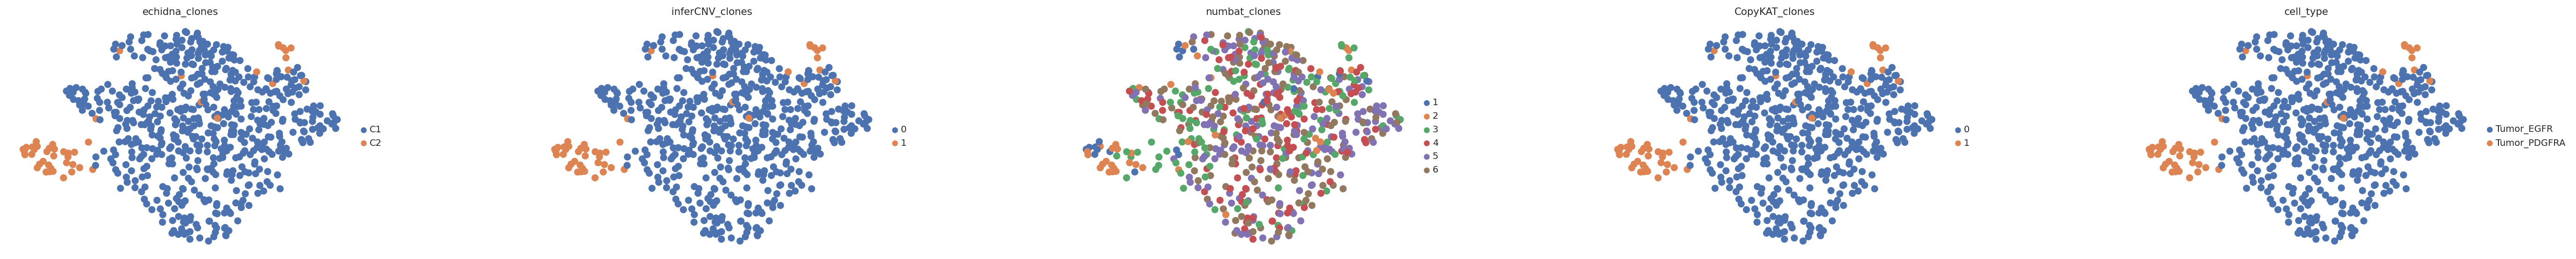

In [63]:
sc.pl.umap(tumor2, color=['echidna_clones', 'inferCNV_clones', 'numbat_clones', 'CopyKAT_clones', 'cell_type'], frameon=False, wspace=0.4, hspace=0.4, ncols=5)

## Xclone

In [64]:
xclone = sc.read_h5ad("benchmarking_data/xclone_def/xclone_defendseq_outputs_ds_combined_data_combined_final.h5ad")
xclone

AnnData object with n_obs × n_vars = 747 × 4105
    obs: 'Type', 'cell_type', 'counts_ratio'
    var: 'GeneName', 'chr', 'start', 'stop', 'arm', 'chr_arm', 'band', 'GeneID', 'ref_avg', 'dispersion', 'gene_dispersion_bse', 'dispersion_capped', 'gene_index'
    uns: 'CNV_ratio', 'Logliklihood', 'chr_dict', 'data_mode', 'data_notes', 'dispersion_base_celltype', 'fit_dispersion_removed_genes', 'genome_mode', 'group_genes', 'guide_CNV_chrs_use_anno_key', 'guide_CNV_chrs_use_layers', 'log', 'neighbors', 'pca', 'rank_marker_genes', 'ref_log_expression_brk'
    obsm: 'WGD_prop', 'X_pca'
    varm: 'PCs'
    layers: 'BAF_extend_post_prob', 'RDR_smooth', 'WGD_bool', 'combine_base_prob', 'corrected_prob', 'plot_prob_merge1', 'plot_prob_merge2', 'plot_prob_merge3', 'plot_prob_merge4', 'posterior_mtx', 'posterior_mtx_log', 'prob1_merge', 'raw_expr', 'rdr_posterior_mtx_denoised'
    obsp: 'connectivities', 'distances'

In [65]:
xclone.var['genes'] = [g.split(".")[-1] for g in list(xclone.var['GeneName'])]
xclone.var['genes']

3          ABCA4
22        ADAM15
23        ADAM30
33        ADORA1
35         ADPRS
          ...   
27582    ZCCHC12
27583    ZCCHC13
27599     ZNF449
27600     ZNF630
27608       ZXDA
Name: genes, Length: 4105, dtype: object

In [66]:
xclone.layers['prob1_merge'].shape

(747, 4105, 4)

In [67]:
from sklearn.preprocessing import StandardScaler
state_score = np.array([-1, 0, 1], dtype=float)
post = xclone.layers['posterior_mtx'].copy()
scores = np.tensordot(post, state_score, axes=(-1, 0))
#H = -(post * np.log(post + 1e-12)).sum(-1)
#input_mat = np.hstack([scores, H])
input_mat = scores
input_mat = StandardScaler().fit_transform(input_mat)
input_mat.shape

(747, 4105)

In [68]:
xclone = pd.DataFrame(input_mat, index=xclone.obs_names, columns=xclone.var['genes'])
xclone

genes,ABCA4,ADAM15,ADAM30,ADORA1,ADPRS,ADSS2,AGBL4-AS1,AGBL4-IT1,AGMAT,AGRN,...,VCX,WDR44,WNK3,XIST,ZC4H2,ZCCHC12,ZCCHC13,ZNF449,ZNF630,ZXDA
AAAGCAAGTCCTCCAA,0.183176,0.183181,0.183185,0.183191,0.183202,0.183214,0.183232,0.183242,0.183252,0.183262,...,-2.800252,-2.800260,-2.800267,-2.800272,-2.800276,-2.800283,-2.800290,-2.800295,-2.800298,-2.800297
AAAGCGGGTACAATGT,0.205700,0.205699,0.205697,0.205697,0.205697,0.205701,0.205702,0.205704,0.205707,0.205711,...,0.274432,0.274431,0.274430,0.274427,0.274423,0.274420,0.274419,0.274414,0.274412,0.274411
AAAGCGGGTATCTGGA,0.205554,0.205558,0.205563,0.205567,0.205572,0.205579,0.205588,0.205597,0.205609,0.205615,...,0.275415,0.275421,0.275427,0.275434,0.275443,0.275450,0.275456,0.275463,0.275461,0.275460
AAAGCTTGTGAGGTGA,0.206445,0.206442,0.206439,0.206435,0.206436,0.206443,0.206440,0.206438,0.206437,0.206433,...,0.273684,0.273688,0.273693,0.273695,0.273695,0.273695,0.273697,0.273701,0.273706,0.273708
AAAGGACGTGCACGCA,0.206006,0.206006,0.206004,0.205998,0.205990,0.205981,0.205976,0.205973,0.205969,0.205965,...,0.273818,0.273812,0.273806,0.273801,0.273797,0.273793,0.273789,0.273788,0.273790,0.273794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCCCATATAACC,0.205932,0.205933,0.205934,0.205933,0.205932,0.205932,0.205928,0.205926,0.205924,0.205924,...,0.332939,0.332938,0.332937,0.332933,0.332931,0.332931,0.332932,0.332931,0.332931,0.332932
TTTGTGAAGGCGGATG,0.205638,0.205640,0.205643,0.205648,0.205640,0.205637,0.205634,0.205632,0.205631,0.205632,...,0.291285,0.291311,0.291340,0.291369,0.291404,0.291441,0.291488,0.291534,0.291585,0.291586
TTTGTGGCAAATTGCT,0.206146,0.206147,0.206148,0.206146,0.206143,0.206140,0.206139,0.206137,0.206136,0.206132,...,0.275338,0.275336,0.275334,0.275334,0.275330,0.275326,0.275321,0.275315,0.275311,0.275309
TTTGTGTTCCTCATGC,-0.252056,-0.252053,-0.252050,-0.252045,-0.252037,-0.252027,-0.252013,-0.252001,-0.251988,-0.251973,...,-2.304711,-2.304709,-2.304708,-2.304706,-2.304702,-2.304699,-2.304695,-2.304693,-2.304694,-2.304693


In [69]:
xclone.T

,AAAGCAAGTCCTCCAA,AAAGCGGGTACAATGT,AAAGCGGGTATCTGGA,AAAGCTTGTGAGGTGA,AAAGGACGTGCACGCA,AAAGGAGCATCGCTTT,AAATGGCCACTCAACA,AACAAAGGTGTGCAAC,AACAAAGGTTGGTTGA,AACAGCAAGCTCCCTG,...,TTTCCTGAGGAACACA,TTTCCTGAGTTATTCC,TTTCTCACACATTGCA,TTTGCATTCCTCAGCT,TTTGTCCCAACCGCCA,TTTGTCCCATATAACC,TTTGTGAAGGCGGATG,TTTGTGGCAAATTGCT,TTTGTGTTCCTCATGC,TTTGTGTTCTACCTAT
genes,,,,,,,,,,,,,,,,,,,,,
ABCA4,0.183176,0.205700,0.205554,0.206445,0.206006,0.206356,-0.099043,0.206099,0.205948,0.205821,...,0.205517,0.205943,0.205854,0.205956,0.206109,0.205932,0.205638,0.206146,-0.252056,0.206167
ADAM15,0.183181,0.205699,0.205558,0.206442,0.206006,0.206346,-0.099044,0.206099,0.205941,0.205821,...,0.205518,0.205938,0.205846,0.205947,0.206108,0.205933,0.205640,0.206147,-0.252053,0.206165
ADAM30,0.183185,0.205697,0.205563,0.206439,0.206004,0.206330,-0.099043,0.206101,0.205938,0.205822,...,0.205517,0.205925,0.205842,0.205938,0.206108,0.205934,0.205643,0.206148,-0.252050,0.206164
ADORA1,0.183191,0.205697,0.205567,0.206435,0.205998,0.206315,-0.099043,0.206104,0.205937,0.205822,...,0.205517,0.205913,0.205837,0.205928,0.206107,0.205933,0.205648,0.206146,-0.252045,0.206162
ADPRS,0.183202,0.205697,0.205572,0.206436,0.205990,0.206295,-0.099042,0.206109,0.205933,0.205824,...,0.205519,0.205899,0.205834,0.205919,0.206106,0.205932,0.205640,0.206143,-0.252037,0.206162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZCCHC12,-2.800283,0.274420,0.275450,0.273695,0.273793,0.271559,-1.797930,0.266974,0.275378,0.275123,...,0.271392,0.259134,0.275381,0.275064,0.273178,0.332931,0.291441,0.275326,-2.304699,0.274862
ZCCHC13,-2.800290,0.274419,0.275456,0.273697,0.273789,0.271557,-1.797927,0.266970,0.275382,0.275123,...,0.271390,0.259140,0.275376,0.275062,0.273175,0.332932,0.291488,0.275321,-2.304695,0.274857
ZNF449,-2.800295,0.274414,0.275463,0.273701,0.273788,0.271554,-1.797924,0.266967,0.275387,0.275124,...,0.271384,0.259145,0.275372,0.275060,0.273173,0.332931,0.291534,0.275315,-2.304693,0.274852


In [70]:
rows = tumor2.obs.index.intersection(xclone.index)
print(xclone.index)
columns = tumor2.var.index.intersection(xclone.T.index)
xclone  = xclone.loc[:, ~xclone.columns.duplicated()]
X_ = tumor2[rows, columns]
xclone = xclone.loc[rows, columns]
eta_df_tumor2 = pd.DataFrame(ech.eta_posterior.cpu().detach().numpy(), columns=tumor2.var_names)
eta_df_tumor2 = eta_df_tumor2.loc[:, columns]
print(X_.shape, xclone.shape, eta_df_tumor2.shape)

Index(['AAAGCAAGTCCTCCAA', 'AAAGCGGGTACAATGT', 'AAAGCGGGTATCTGGA',
       'AAAGCTTGTGAGGTGA', 'AAAGGACGTGCACGCA', 'AAAGGAGCATCGCTTT',
       'AAATGGCCACTCAACA', 'AACAAAGGTGTGCAAC', 'AACAAAGGTTGGTTGA',
       'AACAGCAAGCTCCCTG',
       ...
       'TTTCCTGAGGAACACA', 'TTTCCTGAGTTATTCC', 'TTTCTCACACATTGCA',
       'TTTGCATTCCTCAGCT', 'TTTGTCCCAACCGCCA', 'TTTGTCCCATATAACC',
       'TTTGTGAAGGCGGATG', 'TTTGTGGCAAATTGCT', 'TTTGTGTTCCTCATGC',
       'TTTGTGTTCTACCTAT'],
      dtype='object', length=747)
(641, 2868) (641, 2868) (4, 2868)


In [71]:
X_.X = xclone
cnv_features = []
for i in np.unique(X_.obs['rna_cluster']):
  f = np.mean(X_[X_.obs['rna_cluster'] == i].X, axis=0)
  cnv_features.append(f)
cnv_features = np.array(cnv_features)
cnv_df = pd.DataFrame(cnv_features)
cnv_df.columns = X_.var.index

In [72]:
binned_xclone = bin_cna_profile(cnv_df, gene_coord, DNA_tumor2)
binned_xclone

Discarded 23 genes and 24975 bins


/var/tmp/ipykernel_52724/2481174832.py:36: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = cna_gene_df.loc[:, gene_bins.index].groupby(gene_bins, axis=1).mean()


,chr1:1000000-1100000,chr1:1200000-1300000,chr1:1300000-1400000,chr1:1400000-1500000,chr1:2100000-2200000,chr1:2300000-2400000,chr1:3400000-3500000,chr1:3600000-3700000,chr1:3900000-4000000,chr1:4400000-4500000,...,chrX:139900000-140000000,chrX:140700000-140800000,chrX:143700000-143800000,chrX:147900000-148000000,chrX:150700000-150800000,chrX:150900000-151000000,chrX:151700000-151800000,chrX:152100000-152200000,chrX:153500000-153600000,chrX:153600000-153700000
0,0.001272,0.001236,0.001204,0.019929,0.001201,0.057335,0.057379,0.057337,0.001198,0.001214,...,0.200809,0.080402,0.080415,0.200825,0.200804,0.200827,0.200820,0.200835,0.200800,0.200809
1,0.003543,0.003487,0.003449,-0.001172,0.003425,-0.010540,-0.010525,-0.010608,0.003461,0.003528,...,0.025360,0.104250,0.104269,0.025333,0.025351,0.025263,0.025342,0.025314,0.025365,0.025359
2,0.075949,0.075983,0.075886,0.076781,0.075898,0.078451,0.078430,0.078657,0.075901,0.075903,...,0.119247,0.127928,0.127900,0.119290,0.119264,0.119614,0.119272,0.119341,0.119203,0.119248
3,-0.304118,-0.304183,-0.304100,-0.428125,-0.304117,-0.675770,-0.675711,-0.675816,-0.304202,-0.304471,...,0.077219,-0.580080,-0.579855,0.077233,0.077187,0.077199,0.077231,0.077221,0.077175,0.077222


In [73]:
dna_ground_truth_xclone = DNA_tumor2[DNA_tumor2['genomic_bin'].isin(binned_xclone.columns)]
dna_ground_truth_xclone = dna_ground_truth_xclone[[0, 1, 2, 3]].T
dna_ground_truth_xclone

,10,12,13,14,21,23,34,36,39,44,...,30159,30167,30197,30239,30267,30269,30277,30281,30295,30296
0,4.013265,4.197790,3.261688,3.512392,4.187457,3.603964,4.739523,5.207224,3.532585,3.598505,...,1.971984,2.355019,1.962384,2.018074,2.192267,1.234523,2.666656,2.055245,2.186752,2.596508
1,2.411783,1.906863,2.272173,2.297123,2.524368,2.045273,2.843785,2.907601,3.390641,3.914783,...,2.347817,2.304293,2.450890,2.101616,2.617076,1.924560,3.865777,2.391641,1.751753,1.521272
2,2.844985,2.689197,2.904505,2.701086,2.584704,2.239864,4.144412,2.959730,2.436911,2.870803,...,2.529773,2.471797,2.001374,2.353425,2.580423,0.503769,2.034733,1.450684,0.803447,1.295950
3,2.508811,3.540396,2.584167,2.546456,2.882515,2.727829,4.311988,3.926339,3.927578,3.861551,...,2.855338,2.639853,2.472953,2.708087,2.320844,1.514544,3.133610,3.345894,2.316661,0.968647


In [74]:
from sklearn.cluster import KMeans
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(binned_xclone)
kmeans_labels_str = [str(i) for i in kmeans_labels]

In [75]:
leiden_clusters = tumor2.obs['rna_cluster']
leiden_to_kmeans = dict(zip(np.unique(leiden_clusters), kmeans_labels_str))
tumor2.obs['XClone_allele_clones'] = leiden_clusters.map(leiden_to_kmeans)

# Benchmarking

In [76]:
metrics_adata1 = evaluate_clustering_metrics(tumor2, 'cell_type', 
                                             ['echidna_clones', 'inferCNV_clones', 'numbat_clones', 'CopyKAT_clones', 'XClone_allele_clones'])
metrics_adata1

,Purity,NMI,AMI,ARI
echidna_clones,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
inferCNV_clones,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
numbat_clones,"(0.9390327613104524, 0.008802070605930964)","(0.1483493715393531, 0.017173826602491702)","(0.14394304073063305, 0.018336314465412187)","(0.05996539176594688, 0.009212226157003603)"
CopyKAT_clones,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
XClone_allele_clones,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"


... storing 'XClone_allele_clones' as categorical


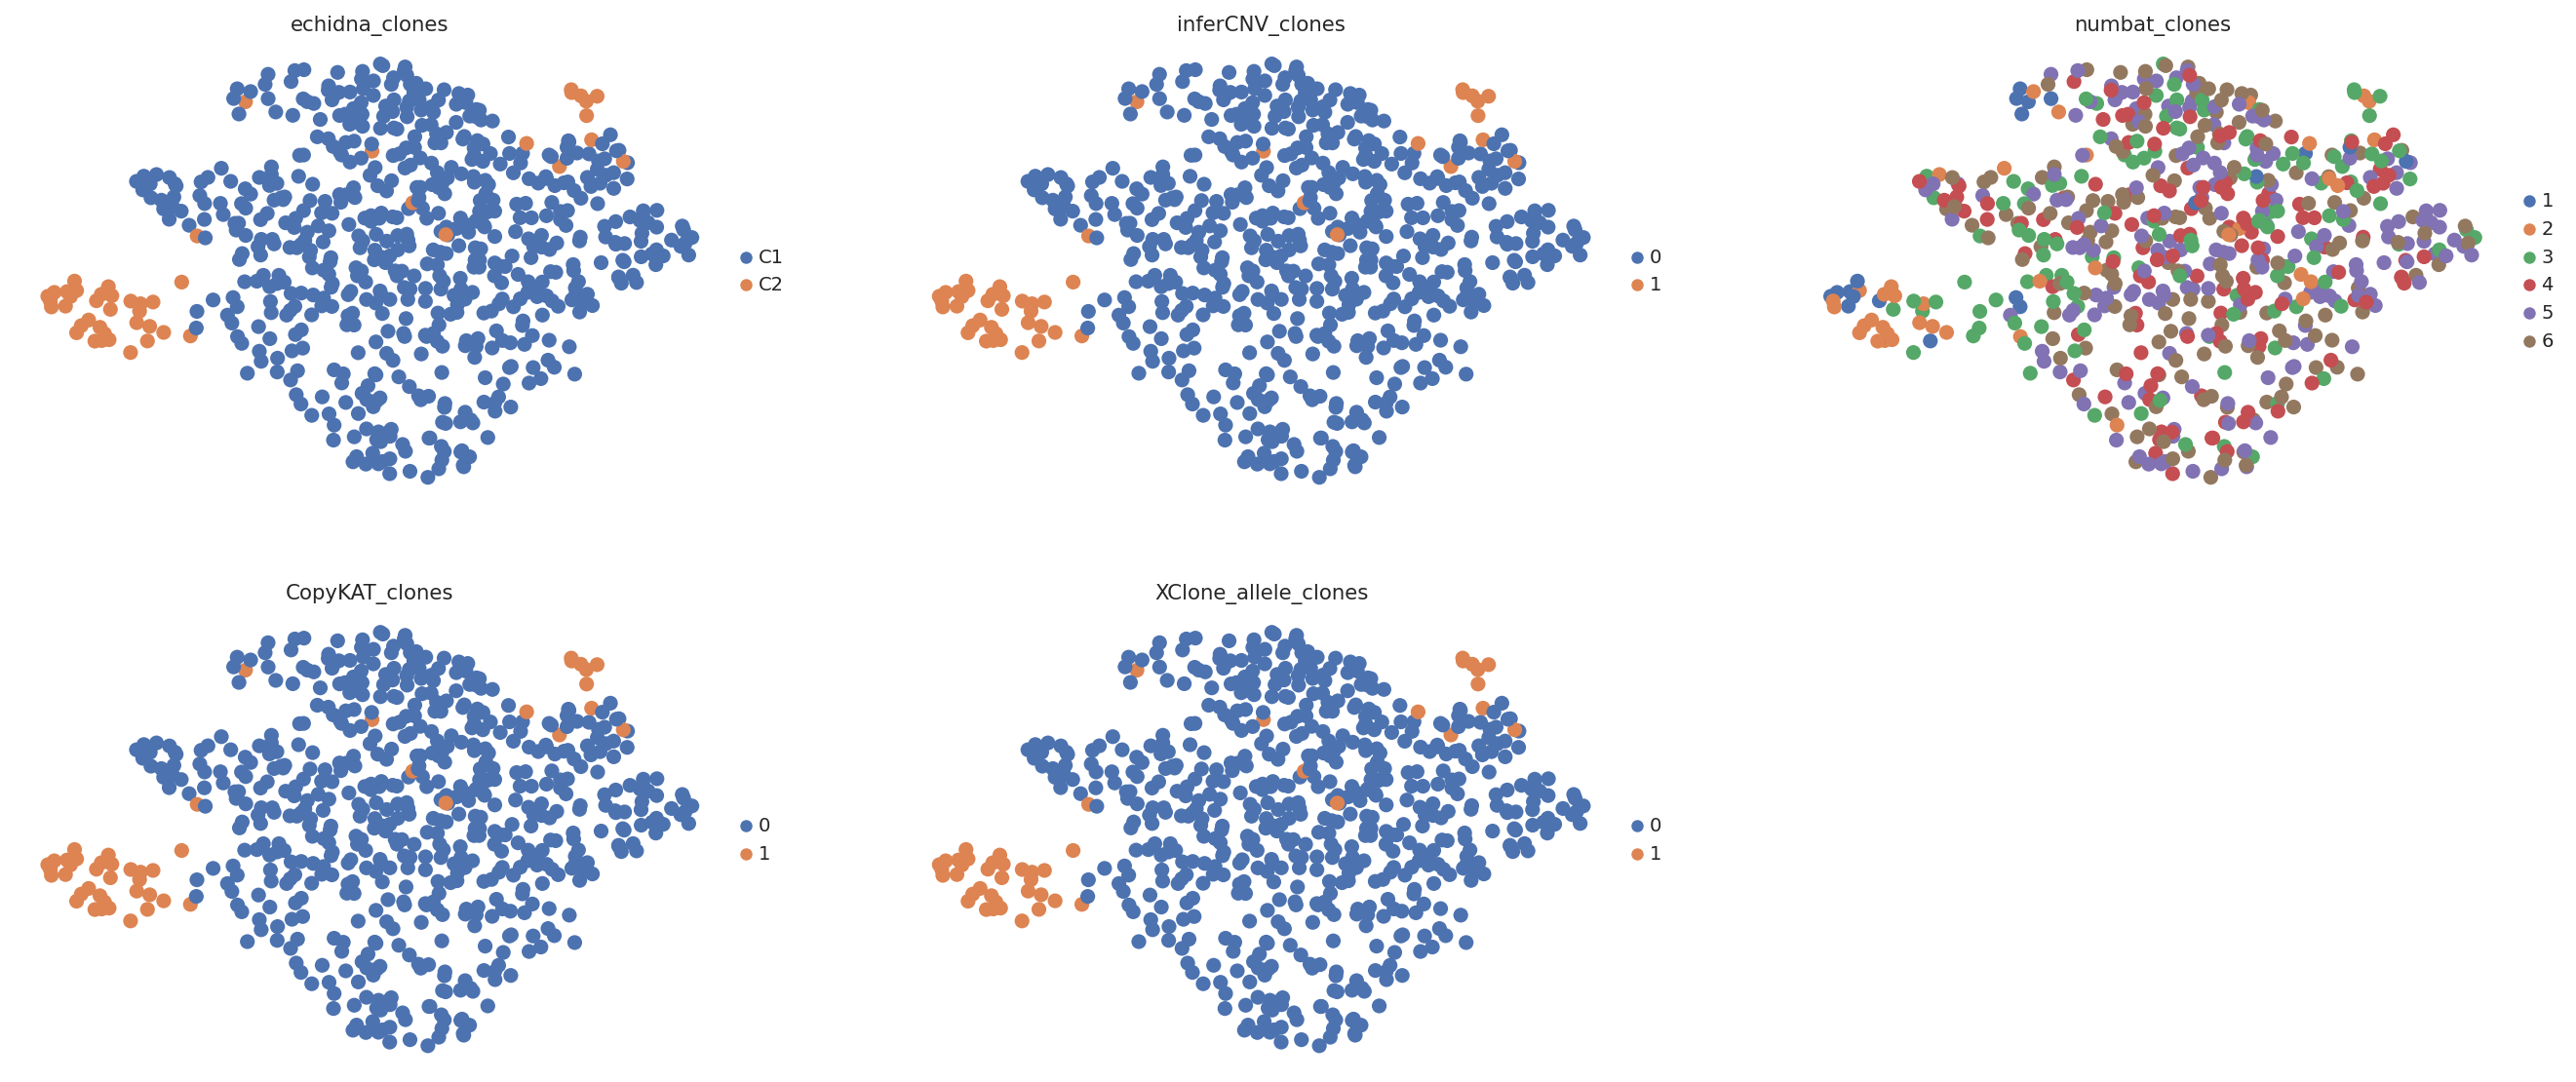

In [77]:
sc.pl.umap(
    tumor2, 
    color=['echidna_clones', 'inferCNV_clones', 'numbat_clones', 'CopyKAT_clones', 'XClone_allele_clones'],
    frameon=False,
    ncols=3
)

In [78]:
binned_eta = np.load("/home/mingxuanzhang/echidna/binned_eta.npy")
binned_infercnv = np.load("/home/mingxuanzhang/echidna/binned_infercnv.npy")
binned_numbat = np.load("/home/mingxuanzhang/echidna/binned_numbat.npy")
binned_copykat = np.load("/home/mingxuanzhang/echidna/binned_copykat.npy")
binned_xclone = np.load("/home/mingxuanzhang/echidna/binned_xclone.npy")
DNA_ground_truth_echidna = np.load("/home/mingxuanzhang/echidna/DNA_ground_truth_echidna.npy")
DNA_ground_truth_infercnv = np.load("/home/mingxuanzhang/echidna/DNA_ground_truth_infercnv.npy")
DNA_ground_truth_numbat = np.load("/home/mingxuanzhang/echidna/DNA_ground_truth_numbat.npy")
DNA_ground_truth_copykat = np.load("/home/mingxuanzhang/echidna/DNA_ground_truth_copykat.npy")
dna_ground_truth_xclone = np.load("/home/mingxuanzhang/echidna/DNA_ground_truth_xclone.npy")

In [79]:
Xs = [binned_eta, binned_infercnv, binned_numbat, binned_copykat, binned_xclone]
Ys = [DNA_ground_truth_echidna, DNA_ground_truth_infercnv,
      DNA_ground_truth_numbat, DNA_ground_truth_copykat, dna_ground_truth_xclone]
models = ["echidna", "inferCNV", "numbat", "CopyKAT", "XClone"]
metrics = evaluate_regression_metrics(Xs, Ys, models, n_boot=100)
metrics

,PearsonR,SpearmanR
echidna,"(0.6060476737901316, (0.5254902868318828, 0.67...","(0.21725560052328735, (0.20846895662192566, 0...."
inferCNV,"(0.30133150570988804, (0.25879269755615925, 0....","(0.11723990023651076, (0.10885279950071206, 0...."
numbat,"(0.38542085604111737, (0.33601595131880224, 0....","(0.635452997753557, (0.6146753151971622, 0.652..."
CopyKAT,"(-0.04449895872004665, (-0.05779419644793018, ...","(-0.1424726928089607, (-0.15147090884001876, -..."
XClone,"(-0.017385715712666994, (-0.031609174189301814...","(0.00244296774316131, (-0.013604119482808694, ..."


In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# ------------------------------------------------------------------ #
# colour map (extend if you add more tools)
# ------------------------------------------------------------------ #
_COLOR_MAP = {
    "echidna":   plt.cm.tab10.colors[0],
    "inferCNV":  plt.cm.tab10.colors[1],
    "numbat":    plt.cm.tab10.colors[2],
    "CopyKAT":   plt.cm.tab10.colors[3],
    "XClone":    plt.cm.tab10.colors[4],
}

def _star(p):
    if p < 1e-10: return '***'
    if p < 1e-5:  return '**'
    if p < 0.05:  return '*'
    return ''

def plot_metric_bar(
    ax,
    metric: str,
    data,                     # DataFrame from evaluate_regression_metrics
    orientation: str = "vertical",
    capsize: int = 4,
):
    """
    Plot `metric` for every model in `data`.

    Each cell in `data` is (mean, (ci_low, ci_high)).
    Bars are sorted high→low, coloured via `_COLOR_MAP`,
    and model names appear on the axis ticks (no legend).
    """

    # -------- gather --------------------------------------------------------
    tools      = list(data.index)
    means, err_low, err_high = [], [], []

    for t in tools:
        mean, (lo, hi) = data.loc[t, metric]

        # --- take absolute values ------------------------------------------
        abs_mean = abs(mean)
        lo_abs, hi_abs = sorted(map(abs, (lo, hi)))  # ensure lo_abs ≤ hi_abs

        means.append(abs_mean)
        err_low.append(abs_mean - lo_abs)
        err_high.append(hi_abs - abs_mean)

    order      = np.argsort(means)[::-1]             # best → worst
    means      = [means[i]      for i in order]
    err_low    = [err_low[i]    for i in order]
    err_high   = [err_high[i]   for i in order]
    labels     = [tools[i]      for i in order]
    colours    = [_COLOR_MAP.get(l, "grey") for l in labels]

    # -------- draw ----------------------------------------------------------
    if orientation == "horizontal":
        y_pos = np.arange(len(labels))
        for j in range(len(labels)):
            ax.barh(
                y_pos[j],
                means[j],
                xerr=[[err_low[j]], [err_high[j]]],
                color=colours[j],
                alpha=0.85,
                capsize=capsize,
            )

        # method names on y‑axis
        ax.set_yticks(y_pos)
        ax.set_yticklabels(labels, fontsize=14)
        ax.tick_params(axis="y", labelsize=14)      # enlarge y‑tick labels
        ax.set_xlabel(metric, fontsize=20)
        ax.grid(axis="x", linestyle="--", alpha=0.4)

        # significance stars (vs. top bar)
        ref = np.random.normal(means[0], np.mean([err_low[0], err_high[0]]), 500)
        for j in range(1, len(labels)):
            comp  = np.random.normal(
                means[j], np.mean([err_low[j], err_high[j]]), 500
            )
            star  = _star(ttest_ind(ref, comp).pvalue)
            if star:
                ax.text(
                    means[j] + err_high[j] + 0.02 * max(means),
                    y_pos[j],
                    star,
                    va="center",
                    fontsize=12,
                )

    else:  # vertical
        x_pos = np.arange(len(labels))
        for j in range(len(labels)):
            ax.bar(
                x_pos[j],
                means[j],
                yerr=[[err_low[j]], [err_high[j]]],
                color=colours[j],
                alpha=0.85,
                capsize=capsize,
            )

        # method names on x‑axis
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels, fontsize=18, rotation=90)
        ax.set_ylabel(metric, fontsize=20)
        ax.tick_params(axis="y", labelsize=18)      # enlarge y‑axis numbers
        ax.grid(axis="y", linestyle="--", alpha=0.4)

        ref   = np.random.normal(means[0], np.mean([err_low[0], err_high[0]]), 500)
        for j in range(1, len(labels)):
            comp = np.random.normal(
                means[j], np.mean([err_low[j], err_high[j]]), 500
            )
            star = _star(ttest_ind(ref, comp).pvalue)
            if star:
                ax.text(
                    x_pos[j],
                    means[j] + err_high[j] + 0.02 * max(means),
                    star,
                    ha="center",
                    fontsize=11,
                )


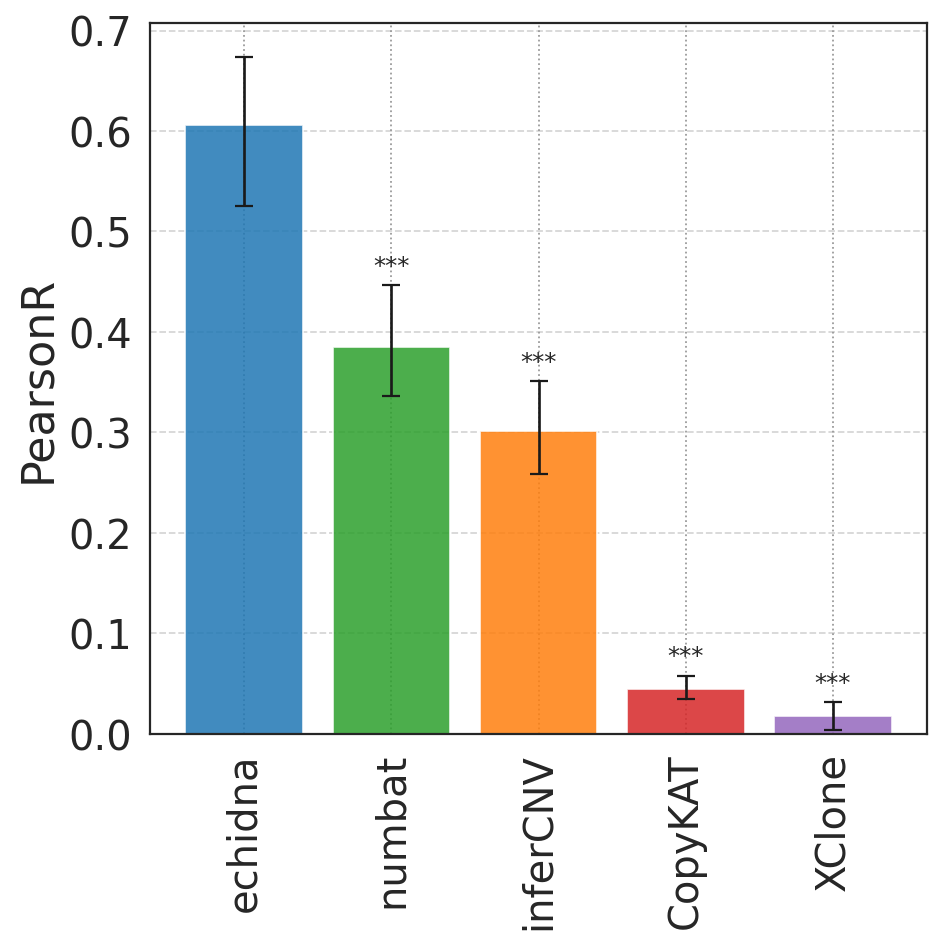

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
plot_metric_bar(ax,
                metric="PearsonR",          
                data=metrics,       
                orientation="vertical")
plt.tight_layout()
plt.savefig("defseq_cna_benchmarking.svg", dpi=300, format='svg', bbox_inches='tight')

In [151]:
np.save("binned_eta.npy", binned_eta.values)
np.save("binned_infercnv.npy", binned_infercnv.values)
np.save("binned_numbat.npy", binned_numbat.values)
np.save("binned_copykat.npy", binned_copykat.values)
np.save("binned_xclone.npy", binned_xclone.values)

In [152]:
np.save("DNA_ground_truth_echidna.npy", DNA_ground_truth_echidna.values)
np.save("DNA_ground_truth_infercnv.npy", DNA_ground_truth_infercnv.values)
np.save("DNA_ground_truth_numbat.npy", DNA_ground_truth_numbat.values)
np.save("DNA_ground_truth_copykat.npy", DNA_ground_truth_copykat.values)
np.save("DNA_ground_truth_xclone.npy", dna_ground_truth_xclone.values)